In [1]:
import Pkg
Pkg.add("PyPlot")
Pkg.add("CSV")
Pkg.add("StatsBase")
Pkg.add("DataFrames")

using PyPlot;
using LinearAlgebra; 
using CSV;
using StatsBase;
using DelimitedFiles;
using DataFrames

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %]  12.2 %==========>                              ]  24.3 %===========>                             ]  26.7 %38.8 %>                   ]  51.0 %]  55.9 %============================>            ]  68.0 %]  80.1 % %> ]  95.2 % Resolving package versions...
 Installed PooledArrays ────── v1.2.1
 Installed StructTypes ─────── v1.4.0
 Installed CategoricalArrays ─ v0.9.3
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
  [324d7699] ↑ CategoricalArrays v0.9.2 ⇒ v0.9.3
  [2dfb63ee] ↑ PooledArrays v1.1.0 ⇒ v1.2.1
  [856f2bd8] ↑ StructTypes v1.3.0 ⇒ v1.4.0
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package 

┌ Info: Recompiling stale cache file /Users/jonathanglaser/.julia/compiled/v1.2/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/jonathanglaser/.julia/compiled/v1.2/DataFrames/AR9oZ.ji for DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1240


In [2]:
function GD(x0,ftot,gradf,L,niter,prox)
    x= Array(x0)
    funval = ftot(x0)
    for i = 1:niter
        x = Array(x - 1/L*gradf(x))
        funval = [funval;ftot(x)]
    end
    return (x,funval)
end  

function GDPolyak(x0,f,gradf,fstar,niter,polyak_version)
    x= Array(x0)
    funval = [f(x0)]
    steps = []
    for i = 1:niter
    
        gd = gradf(x)
        gd2 = norm(gd)^2
        
        alpha = (f(x) - fstar)/gd2;
        x = Array(x - polyak_version*alpha*gd);
        
        steps = [steps;polyak_version*alpha]
        funval = [funval;f(x)]
    end
    return (x,funval,steps)
end  

function AccGD(x0,ftot,gradf,prox,L,mu,niter)
    x = Array(x0)
    y = Array(x0)
    theta = 1

    cond = mu/L
    mus = Inf
    funval = ftot(x0)

    for i = 1:niter
        theta_ = (1+sqrt(1+ 4*theta^2))/2
        if mu > 0
            cond = mu/L
            beta = (1-sqrt(cond))/(1+sqrt(cond))
        else
            beta = (theta-1)/theta_
        end
        theta = theta_
        y_ = x-1/L*gradf(x)
        x = y_ + beta*(y_-y)
        y = Array(y_)
        funval = [funval;ftot(y)]
    end
    return (y,funval)
end
   


function AccGDPolyak(x0,f,g,gradf,prox,L,fstar,niter,iscomposite,version)
    x = Array(x0)
    y = Array(x0)
    v = Array(x0)
    funval = [(f(y)+g(y))]
    mu_ = L
    for i = 1:niter
        y_ = prox(x-1/L*gradf(x))
        
        if iscomposite
            y_L = prox(y_-1/L*gradf(y_))
        
            alpha = (f(y_)+g(y_)-fstar)/(-2*L*(g(y_L) - g(y_) + gradf(y_)[:]'*(y_L[:]-y_[:]) + 0.5*L*norm(y_L-y_)^2))
        else
           alpha = (f(y_)+g(y_)-fstar)/norm(gradf(y_))^2 
        end
        if alpha > 0
                if version == 1
                    mu_ = 1/alpha/2
                else
                    mu_ = min(mu_,1/alpha/2)
                end
        end
        cond = mu_/L
        
        beta = (1-sqrt(cond))/(1+sqrt(cond))
        x_ = y_ + beta*(y_-y)
        
        y = Array(y_)

        x = Array(x_)
        
        funval = [funval;(f(y)+g(y))]
        

    end
    return (y,funval)
    
end



AccGDPolyak (generic function with 1 method)

In [3]:
Sonar = CSV.read("sonar_csv.csv", DataFrame)
Sonar = convert(Matrix,Sonar)
y_sonar = Sonar[:,end]
y_sonar = 1*(y_sonar.=="Rock")
y_sonar = 2*y_sonar.-1
Sonar = Sonar[:,1:(end-1)]
Sonar = convert(Matrix{Float64},Sonar)
Sonar = Sonar .- [mean(Sonar[:,i]) for i = 1:size(Sonar,2)]'
Sonar = Sonar ./ [StatsBase.std(Sonar[:,i]) for i = 1:size(Sonar,2)]'
y_sonar = convert(Array{Float64},y_sonar)



2000×500 Array{Float64,2}:
  0.510373   -0.213756    0.689835    …  -0.317776  -0.8859      0.222031 
  0.198933   -0.843181   -1.28964         0.640936   0.0543462   1.03519  
  0.821814    1.93954    -0.28705         0.419695  -0.24116     0.299474 
 -0.268228    0.250031   -0.00426744     -0.096535  -0.375481   -1.13323  
  0.354653    0.614434    0.458467        1.5259    -0.348616    0.802857 
 -0.112508    0.415669   -1.52101     …  -1.49773   -1.36946     0.376918 
  0.354653    1.64139    -0.312757       -0.612765  -1.23513    -0.242631 
 -1.20255    -0.511905    2.25799         1.30466    0.564766   -0.0490217
  0.354653    0.481924    1.22969        -0.760259   0.618494   -1.94639  
  2.2233     -1.17446     1.53818         0.198454   1.98857     0.222031 
 -0.579669   -1.24071    -1.36676     …   1.30466    1.12891     1.03519  
  0.666094   -0.147501    0.458467        0.935925  -0.0799746  -0.203909 
 -2.44831     0.0843926   0.766957        0.714684  -0.0531105   1.2288  

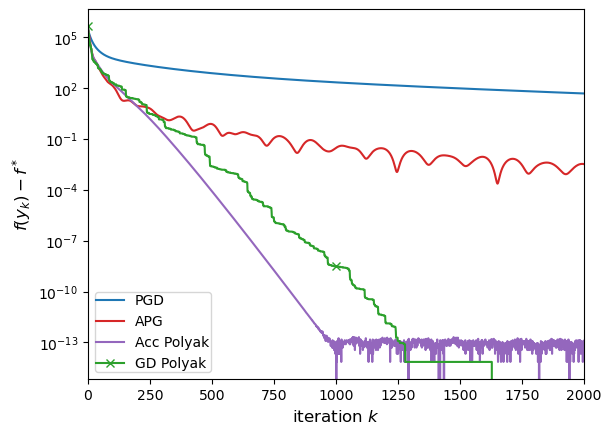

PyObject <matplotlib.legend.Legend object at 0x7fdf3b3b3280>

In [4]:
A = Sonar
y= y_sonar


(m,n) = size(A)
B = A'*A

L = opnorm(B) 
mu = eigmin(B)

Ay = A'*y

yy= norm(y)^2


function fun_LS(x)    
      return 0.5*(x'*B*x -2*x'*Ay +yy) 
end
function grad_LS(x)
    return B*x- Ay + 0*1.5*0.5*x*norm(x)^(1.5-2)
end

function prox_LS(x::Array{Float64,1})
    return x
end
z(x) =0
x0 = 10(randn(n))
fstar = 0.5*norm(A*inv(B)*Ay - y)^2

max_iter = 20000
(ygd,funvalgd) = GD(x0,fun_LS,grad_LS,L,max_iter,prox_LS)
(y_apg_mu,funval_apg_mu) = AccGD(x0,fun_LS,grad_LS,prox_LS,L,mu,max_iter)
(y_apg,funval_apg) = AccGD(x0,fun_LS,grad_LS,prox_LS,L,0,max_iter)

iscomposite = false
(y_adapt1,funval_adapt1) = AccGDPolyak(x0,fun_LS,z,grad_LS,prox_LS,L,fstar,max_iter,iscomposite,1)
(y_adapt2,funval_adapt2) = AccGDPolyak(x0,fun_LS,z,grad_LS,prox_LS,L,fstar,max_iter,iscomposite,2)
(ygd,funvalgdpl,steps) = GDPolyak(x0,fun_LS,grad_LS,fstar,max_iter,1)

fig = figure()
semilogy((funvalgd.-fstar),marker="None",markevery=500,color="tab:blue",label="PGD")
semilogy(funval_apg.-fstar,marker="None",markevery=1000,color="tab:red",label = "APG")
semilogy(funval_adapt2.-fstar,marker="None",markevery=1000,color="tab:purple",label="Acc Polyak")
semilogy([minimum(funvalgdpl[1:i]) for i = 1:length(funvalgdpl)].-fstar,marker="x",markevery=1000,color="tab:green",label="GD Polyak")

ylabel(L"$f(y_k) - f^*$",fontsize=12)
xlabel(L"iteration $k$",fontsize=12)
xlim([0;2000])
legend(borderpad=0.1,fontsize=10)